# Trabajo Práctico 4 - Regularización aplicada a la EPH 

## Gil Deza, Hüppi Lo Prete, Walker 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error

In [ ]:
conda install python-graphviz

In [2]:
# Utilizamos el código de la clase tutorial para crear un botón para ocultar el código 
#Fuente: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

In [3]:
# Aplicamos un comando para que no salten los warnings
import warnings
warnings.filterwarnings("ignore")

### Parte I

Para esta parte recuperaremos lo realizado en los TPs anteriores.

#### 1) 

In [4]:
# Abrimos la base de hogar 
df_ba=pd.read_excel("usu_hogar_T122.xls")
# Armamos un nuevo df solo con las observaciones de Buenos Aires y Gran Buenos Aires
df_ba = df_ba.loc[df_ba['AGLOMERADO'].isin([32, 33])]
# Abrimos la tabla de usuarios 
df_usu=pd.read_excel("usu_individual_T122.xls")

#### 2) 

In [5]:
df_ba_unido = pd.merge(df_ba, df_usu, on=("CODUSU","NRO_HOGAR"), how="inner", validate="one_to_many")
df_ba_unido

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR,REALIZADA,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,IV1,...,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y
0,TQRMNOQSYHMOTOCDEIJAH00698520,2022,1,1,1,1,S,33,4625,2,...,NaN,0,0.0,0,NaN,0,0.0,NaN,0,4410
1,TQRMNOPSSHKKMMCDEIIAD00780111,2022,1,1,1,1,S,32,803,1,...,NaN,8,103750.0,10,NaN,10,10.0,NaN,8,1440
2,TQRMNOPSSHKKMMCDEIIAD00780111,2022,1,1,1,1,S,32,803,1,...,NaN,8,103750.0,10,NaN,10,10.0,NaN,8,1440
3,TQRMNORSUHLMNPCDEIIAD00718267,2022,1,1,1,1,S,32,2785,2,...,NaN,10,145000.0,10,NaN,10,10.0,NaN,9,4073
4,TQRMNORSUHLMNPCDEIIAD00718267,2022,1,1,1,1,S,32,2785,2,...,NaN,10,145000.0,10,NaN,10,10.0,NaN,9,4073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,TQRMNOPQSHMMKPCDEIJAH00780780,2022,1,1,1,1,S,33,2607,1,...,NaN,6,24500.0,4,NaN,3,3.0,NaN,4,5084
6702,TQRMNOPWPHMLLLCDEIJAH00780781,2022,1,1,1,1,S,33,2325,1,...,NaN,4,34000.0,5,NaN,5,5.0,NaN,6,4528
6703,TQRMNOPWPHMLLLCDEIJAH00780781,2022,1,1,1,1,S,33,2325,1,...,NaN,4,34000.0,5,NaN,5,5.0,NaN,6,4528
6704,TQRMNORUVHLLKQCDEIJAH00718720,2022,1,1,1,1,S,33,2102,1,...,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0


Eliminamos todas las columnas duplicadas luego del merge, dado que se encontraban en ambas bases.

In [6]:
df_ba_unido.drop(columns=(df_ba_unido.filter(regex='_y')), inplace=True)

#### 3)

Para la limpieza a conciencia de la base de datos eliminaremos, en primer lugar, aquellas variables que contengan más del 50% de sus observaciones con valores faltantes. Esto se debe a que consideramos que serán variables que no aportarán valor informativo suficiente a nuestros modelos predictivos, sino que traerán aparejados problemas para su estimación. Como nuestra base contiene en total 6706 observaciones, realizamos el corte de 50% en 3372 observaciones.

In [7]:
# Limpiamos la base de los datos nulos
# Eliminamos columnas que tienen más del 50% de observaciones vacías 
df_ba_unido_limpio = df_ba_unido.dropna(axis=1, thresh= len(df_ba_unido)/2 )

En segundo lugar, eliminamos los outliers de nuestras variables, dado que también pueden generar problemas en nuestras predicciones. Consideramos outliers todas las observaciones que están en el cuantil 1% superior e inferior.

In [8]:
# Eliminamos outliers 
for column in df_ba_unido_limpio.columns[1:]:
    if df_ba_unido_limpio[column].dtype== "str":
        continue
    elif df_ba_unido_limpio[column].dtype== "object":
        continue
    else:
        q_low = df_ba_unido_limpio[column].quantile(q = 0.01)
        q_hi = df_ba_unido_limpio[column].quantile(q = 0.99)
        f_filtrada = df_ba_unido_limpio[(df_ba_unido_limpio[column]<q_hi) & (df_ba_unido_limpio[column]>q_low)]

En tercer lugar, chequeamos cuál es el contenido de las variables que nos generarían problemas al no ser numéricas:

In [9]:
for column in f_filtrada.columns[1:]:
    if f_filtrada[column].dtype == "int64":
        continue
    elif f_filtrada[column].dtype == "float64":
        continue
    else:
        print(column, "es una variable", f_filtrada[column].dtype)
#print(list(f_filtrada.CH05))
#print(list(f_filtrada.MAS_500_x))

MAS_500_x es una variable object
CH05 es una variable object



Observamos que CH05 contiene la fecha de nacimiento de los individuos (con lo cual podríamos borrarla, dado que tenemos su edad en la base también)

MAS_500_x contienen una letra que indica el tamaño del aglomerado. Al habernos quedado con las observaciones de BsAs y Gran BsAs, todas tienen una "S".

Debido a esto, consideramos que podemos deshacernos de tales variables sin mayores problemas.

In [10]:
f_filtrada.drop(columns="CH05", inplace=True)
f_filtrada.drop(columns="MAS_500_x", inplace=True)

A continuación, chequearemos y eliminaremos todas las observaciones que tengan valores negativos sin sentido, por ejemplo, para el ingreso o la edad:

In [11]:
print(f_filtrada[f_filtrada["ITF_x"] < 0])
#Obtenemos un dataframe vacío, por lo que no hay observaciones que cumplan con esas características.

print(f_filtrada[f_filtrada["IPCF_x"] < 0])
#Obtenemos un dataframe vacío, por lo que no hay observaciones que cumplan con esas características.

print(f_filtrada[f_filtrada["P21"] < 0])
#Obtenemos un dataframe con datos de ingreso negativos, por lo que procedemos a eliminarlos.

print(f_filtrada[f_filtrada["P47T"] < 0])
#Obtenemos un dataframe con datos de ingreso negativos, por lo que procedemos a eliminarlos.

print(f_filtrada[f_filtrada["CH06"] < 0])
#Obtenemos un dataframe con datos de edad negativos, por lo que procedemos a eliminarlos.

#Eliminamos las observaciones con edades negativas.
f_filtrada = f_filtrada[f_filtrada.CH06>=0]

#Eliminamos las observaciones con ingreso negativo.
f_filtrada = f_filtrada[f_filtrada.P21>=0]

#Eliminamos las observaciones con ingreso negativo.
f_filtrada = f_filtrada[f_filtrada.P47T>=0]

#Chequeamos que al imprimir el dataframe seleccionando edades negativas devuelva un dataframe vacío.
print(f_filtrada[f_filtrada["CH06"] < 0])

#Chequeamos que al imprimir el dataframe seleccionando ingresos negativos devuelva un dataframe vacío.
print(f_filtrada[f_filtrada["P21"] < 0])

#Chequeamos que al imprimir el dataframe seleccionando ingresos negativos devuelva un dataframe vacío.
print(f_filtrada[f_filtrada["P47T"] < 0])

Empty DataFrame
Columns: [CODUSU, ANO4_x, TRIMESTRE_x, NRO_HOGAR, REALIZADA, REGION_x, AGLOMERADO_x, PONDERA_x, IV1, IV2, IV3, IV4, IV5, IV6, IV7, IV8, IV9, IV10, IV11, IV12_1, IV12_2, IV12_3, II1, II2, II3, II3_1, II4_1, II4_2, II4_3, II5, II5_1, II6, II6_1, II7, II8, II9, V1, V2, V21, V22, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19_A, V19_B, IX_TOT, IX_MEN10, IX_MAYEQ10, ITF_x, DECIFR_x, RDECIFR_x, GDECIFR_x, ADECIFR_x, IPCF_x, DECCFR_x, RDECCFR_x, GDECCFR_x, ADECCFR_x, PONDIH_x, VII1_1, VII1_2, VII2_1, VII2_2, VII2_3, VII2_4, COMPONENTE, H15, CH03, CH04, CH06, CH07, CH08, CH09, CH10, CH11, CH12, CH13, CH15, CH16, NIVEL_ED, ESTADO, CAT_OCUP, CAT_INAC, PP02C1, PP02C2, PP02C3, PP02C4, ...]
Index: []

[0 rows x 133 columns]
Empty DataFrame
Columns: [CODUSU, ANO4_x, TRIMESTRE_x, NRO_HOGAR, REALIZADA, REGION_x, AGLOMERADO_x, PONDERA_x, IV1, IV2, IV3, IV4, IV5, IV6, IV7, IV8, IV9, IV10, IV11, IV12_1, IV12_2, IV12_3, II1, II2, II3, II3_1, II4_1, II4_2, II4_

#### 4) 

Construimos una variable que indique la proporción de niños menores de 10 años en el hogar:

In [12]:
f_filtrada["niños_prop"] = f_filtrada["IX_MEN10"]/f_filtrada["IX_TOT"]

Construimos una variable que identifique si el cónyuge del jefe de hogar trabaja:

In [13]:
f_filtrada["conyuge_trabaja"] = 0

for index, row in f_filtrada.iterrows():
    if row["CH03"] == 2:
        if row["ESTADO"] == 1:
            f_filtrada.loc[index, "conyuge_trabaja"] = 1

Construimos una variable que indique si quien contesta la encuesta es migrante. Entendemos como migrantes a aquellos individuos que no son oriundos de la localidad en la que residen y además se desplazaron en los últimos 5 años. 

In [14]:
f_filtrada["migrante"] = 0

for index, row in f_filtrada.iterrows():
    if (row["CH15"] != 1 & row["CH15"] != 2):
        if (row["CH16"] != 1  & row["CH16"] != 2):
            f_filtrada.loc[index, "migrante"] = 1

### 5)

Creamos un grafico de dispersión entre la proporción de niños en el hogar y el máximo nivel educativo de quien contesta

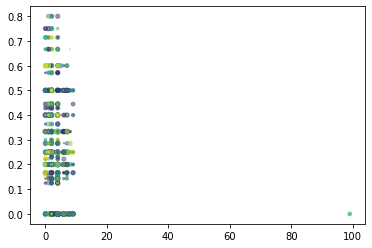

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = f_filtrada["CH12"]
y = f_filtrada["niños_prop"]
colors = np.random.rand(5231)
area = (20 * np.random.rand(5231))**1
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Heatmap de matriz de correlación')

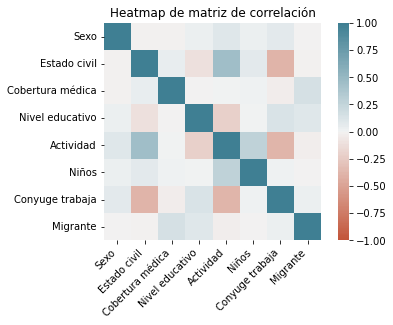

In [16]:
from heatmap import heatmap, corrplot
import seaborn as sns
data_cor = f_filtrada[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'niños_prop', 'conyuge_trabaja','migrante']]
data_cor
#Armamos la matriz de correlación
corr = data_cor.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
#Cambiamos las labels
ax.set_xticklabels(
    ax.set_xticklabels(["Sexo", "Estado civil", "Cobertura médica", "Nivel educativo", "Actividad", "Niños", "Conyuge trabaja", "Migrante"]),
    rotation=45,
    horizontalalignment='right'
);
ax.set_yticklabels(
    ax.set_yticklabels(["Sexo", "Estado civil", "Cobertura médica", "Nivel educativo", "Actividad", "Niños", "Conyuge trabaja", "Migrante"]),
    rotation=0,
);
#Sumamos el título
plt.title("Heatmap de matriz de correlación")

#### 6)

In [17]:
# Importamos la tabla de equivalencias 
tabla_adulto=pd.read_excel("tabla_adulto_equiv.xlsx", header = 4, nrows=23, )
tabla_adulto.rename({'Unnamed: 0':'Edad','Unnamed: 1':'Mujeres','Unnamed: 2':'Varones'}, axis=1, inplace = True)
# Generamos una nueva tabla para mujeres
tabla_adulto_m = tabla_adulto[["Edad","Mujeres"]]

# Generamos una nueva tabla para varones
tabla_adulto_v = tabla_adulto[["Edad","Varones"]]
# Generamos Ids para mujeres
N=0 
temp = 0
lista = []
for i in range(23):
    temp = "M" + str(N)
    lista.append(temp)
    N=N+1

tabla_adulto_m["id"]=lista
tabla_adulto_m["Varon"]=0
tabla_adulto_m.rename({'Mujeres':'Valor'}, axis=1, inplace = True)
# Generamos Ids para varones
N=0 
temp_v = 0
lista_v = []
for i in range(23):
    temp_v = "V" + str(N)
    lista_v.append(temp_v)
    N=N+1

tabla_adulto_v["id"]=lista_v
tabla_adulto_v["Varon"]=1
tabla_adulto_v.rename({'Varones':'Valor'}, axis=1, inplace = True)

# Unimos las tablas verticalmente
tabla_adulto_total = tabla_adulto_v.append(tabla_adulto_m) 
tabla_adulto_total.reset_index(inplace=True, drop=True)

In [18]:
# Generamos un loop para asignar los códigos correspondientes (de sexo y edad) a cada observación de la base original
for index, row in f_filtrada.iterrows(): 
    if row["CH06"]<1:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V0"
        else: 
            f_filtrada.loc[index,"id"]="M0"
    elif row["CH06"]==1:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V1"
        else: 
            f_filtrada.loc[index,"id"]="M1"
    elif row["CH06"]==2:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V2"
        else: 
            f_filtrada.loc[index,"id"]="M2"
    elif row["CH06"]==3:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V3"
        else: 
            f_filtrada.loc[index,"id"]="M3"
    elif row["CH06"]==4:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V4"
        else: 
            f_filtrada.loc[index,"id"]="M4"
    elif row["CH06"]==5:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V5"
        else: 
            f_filtrada.loc[index,"id"]="M5"
    elif row["CH06"]==6:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V6"
        else: 
            f_filtrada.loc[index,"id"]="M6"
    elif row["CH06"]==7:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V7"
        else: 
            f_filtrada.loc[index,"id"]="M7"
    elif row["CH06"]==8:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V8"
        else: 
            f_filtrada.loc[index,"id"]="M8"
    elif row["CH06"]==9:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V9"
        else: 
            f_filtrada.loc[index,"id"]="M9"
    elif row["CH06"]==10:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V10"
        else: 
            f_filtrada.loc[index,"id"]="M10"
    elif row["CH06"]==11:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V11"
        else: 
            f_filtrada.loc[index,"id"]="M11"
    elif row["CH06"]==12:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V12"
        else: 
            f_filtrada.loc[index,"id"]="M12"
    elif row["CH06"]==13:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V13"
        else: 
            f_filtrada.loc[index,"id"]="M13"
    elif row["CH06"]==14:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V14"
        else: 
            f_filtrada.loc[index,"id"]="M14"
    elif row["CH06"]==15:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V15"
        else:
            f_filtrada.loc[index,"id"]="M15"
    elif row["CH06"]==16:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V16"
        else: 
            f_filtrada.loc[index,"id"]="M16"
    elif row["CH06"]==17:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V17"
        else: 
            f_filtrada.loc[index,"id"]="M17"
    elif (row["CH06"]> 17 and row["CH06"]<30):
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V18"
        else: 
            f_filtrada.loc[index,"id"]="M18"
    elif (row["CH06"]>= 30 and row["CH06"]<46):
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V19"
        else: 
            f_filtrada.loc[index,"id"]="M19"
    elif (row["CH06"]>= 46 and row["CH06"]<61):
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V20"
        else: 
            f_filtrada.loc[index,"id"]="M20"
    elif (row["CH06"]>= 61 and row["CH06"]<75):
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V21"
        else: 
            f_filtrada.loc[index,"id"]="M21"
    else:
        if row["CH04"]==1:
            f_filtrada.loc[index,"id"]="V22"
        else: 
            f_filtrada.loc[index,"id"]="M22"

In [19]:
#Chequeamos que se hayan asignado correctamente los id
f_filtrada[["CH04","CH06","id"]] 
# Unimos la tabla original con la tabla de equivalencias calóricas, a partir de los id generados 
df_ba_unido = pd.merge(f_filtrada, tabla_adulto_total, on="id")
# Renombramos la variable de adulto_equiv 
df_ba_unido.rename({'Valor':'adulto_equiv'}, axis=1, inplace = True)
# Sumamos los valores calóricos por hogar y lo asignamos como una nueva variable a cada individuo
df_ba_unido["ad_equiv_hogar"] = df_ba_unido.groupby(["CODUSU", "NRO_HOGAR"])["adulto_equiv"].transform('sum')

In [20]:
# Chequeamos la cantidad de personas que no declararon el ITF
print("La cantidad de personas que no respondieron cuál es su ingreso total familiar es:", df_ba_unido['ITF_x'].value_counts()[0])
# Guardamos en un nuevo data frame las personas que sí respondieron a ITF
respondieron = df_ba_unido[df_ba_unido["ITF_x"]!=0]
# Chequeamos que se haya guardado bien
print(respondieron["ITF_x"])
# Guardamos en un nuevo data frame las personas que no respondieron a ITF
norespondieron = df_ba_unido[df_ba_unido["ITF_x"]==0]
# Chequeamos que se haya guardado bien
print(norespondieron["ITF_x"])
# Agregamos la columna a la base de los que respondieron
respondieron["ingreso_necesario"] = 27197.64 * respondieron["ad_equiv_hogar"]
#respondieron[["ingreso_necesario" "ad_equiv_hogar"]]
print(respondieron ["ingreso_necesario"])

La cantidad de personas que no respondieron cuál es su ingreso total familiar es: 1542
1       435000
2       120000
3        15000
6       210000
8        63000
         ...  
5224     22000
5225     16000
5226    160000
5228     53500
5230    282000
Name: ITF_x, Length: 3689, dtype: int64
0       0
4       0
5       0
7       0
14      0
       ..
5218    0
5219    0
5221    0
5227    0
5229    0
Name: ITF_x, Length: 1542, dtype: int64
1        69353.9820
2        96551.6220
3        97639.5276
6        89208.2592
8        96551.6220
           ...     
5224    132180.5304
5225     60922.7136
5226     60650.7372
5228     61194.6900
5230     88664.3064
Name: ingreso_necesario, Length: 3689, dtype: float64


#### 7)

In [21]:
#Creamos la columna que identifica si el individuo es pobre
for index, row in respondieron.iterrows(): 
    if row["ITF_x"]< respondieron.loc[index, "ingreso_necesario"]:
        respondieron.loc [index,"pobre"] = 1
    else:
        respondieron.loc[index, "pobre"] = 0

#### 8)

In [22]:
print(respondieron)

                             CODUSU  ANO4_x  TRIMESTRE_x  NRO_HOGAR  \
1     TQRMNORSUHLMNPCDEIIAD00718267    2022            1          1   
2     TQRMNOQUUHLMTSCDEIJAH00719592    2022            1          1   
3     TQRMNORRUHLLKNCDEIJAH00718712    2022            1          1   
6     TQRMNOQXUHJMMUCDEIJAH00693031    2022            1          1   
8     TQRMNOPQPHMMQLCDEIJAH00701137    2022            1          1   
...                             ...     ...          ...        ...   
5224  TQRMNORQYHMMMPCDEIJAH00698194    2022            1          1   
5225  TQSMNOTXQHKMLQCDEIJAH00780680    2022            1          1   
5226  TQRMNOQWPHKOTMCDEIJAH00780657    2022            1          1   
5228  TQRMNOSRWHLOLSCDEIJAH00719039    2022            1          1   
5230  TQRMNOQRXHMMPPCDEIJAH00780782    2022            1          1   

      REALIZADA  REGION_x  AGLOMERADO_x  PONDERA_x  IV1  IV2  ...  niños_prop  \
1             1         1            32       2785    2    3  ... 

In [23]:
pondih = respondieron.groupby(['CODUSU', 'NRO_HOGAR']).agg({'PONDIH_x' : 'sum', "pobre" : "mean"})
# Para dentro de un mismo hogar todos deberían tener el mismo valor de Pobre, así que calcular el promedio va a dar que es pobre si todos son pobres y viceversa 
pondih.loc[pondih['pobre'] == 1, "PONDIH_x"].sum() 
pondih["PONDIH_x"].sum()
# Calculamos el porcentaje de hogares bajo la linea de pobreza 
hogares_pobres = (pondih.loc[pondih['pobre'] == 1, "PONDIH_x"].sum()) / (pondih["PONDIH_x"].sum())
print("El pocentaje de hogares bajo la linea de pobreza es", hogares_pobres)

El pocentaje de hogares bajo la linea de pobreza es 0.34064281543033087


La tasa de pobreza que obtenemos se asemeja a la del INDEC. Para el primer semestre de 2022 para AMBA obtenemos una tasa de 34.06%, mientras que en el INDEC la tasa de pobreza para esta misma región es de 28.2%.

In [24]:
#Concatenamos CODUSU y el número de hogar para poder quedarnos solo con una observación por hogar.
for index, row in respondieron.iterrows(): 
    respondieron.loc[index, "hogar"] = str(respondieron.loc[index, "CODUSU"]) + str(respondieron.loc[index, "NRO_HOGAR"])    

#Eliminamos las observaciones repetidas de un mismo hogar
respondieron_hogares = respondieron.drop_duplicates(subset = "hogar", keep='first')

# Sumamos los ponderadores de pobres y no pobres  
pond_pob = 0

for index, row in respondieron_hogares.iterrows(): 
    if respondieron_hogares.loc [index,"pobre"] == 1:
        pond_pob += respondieron_hogares.loc [index,"PONDIH_x"]
    else:
        continue
print("La suma del PONDIH de los hogares pobres es", pond_pob)

#Sumamos los ponderadores de todos los hogares
pond_tot = respondieron_hogares["PONDIH_x"].sum()
print("La suma del PONDIH de todos los hogares",pond_tot)

#Calculamos la tasa de pobreza por hogar
print("La tasa de hogares bajo la linea de pobreza de AMBA es", (pond_pob/pond_tot*100),"%") 

La suma del PONDIH de los hogares pobres es 1262824
La suma del PONDIH de todos los hogares 4978383
La tasa de hogares bajo la linea de pobreza de AMBA es 25.366148004281712 %


La tasa de pobreza que obtenemos se asemeja a la del INDEC. Para el primer semestre de 2022 para AMBA obtenemos una tasa de 25.36%, mientras que en el INDEC la tasa de pobreza para esta misma región es de 28.2%.

### Parte II

#### 1)

In [25]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

def evalua_metodo(nombre_modelo, X_train, y_train, X_test, y_test, p=None, c=None, n_components=None, k_rango_min=None, 
                  k_rango_max=None) :
    
    '''
    Esta función ajusta los datos al modelo provisto y calcula las siguientes métricas:
    curva de ROC, valores AUC y el accuracy score del método. Automáticamente la función importa distintos paquetes de
    sklearn.
    Input:
        modelo (str): Modelo a utilizar. Las opciones son "logit", "adl" (análisis discriminante lineal), "knn" (vecinos
        cercanos), "arbol" (árbol de regresión), "bagging" (con árboles de regresión), "random_forest" (con árboles de regresión),
        "gradient_boosting" (gradient boosting de árboles de regresión)
        X_train (df): Partición de la muestra de predictores para entrenamiento
        y_train (df): Partición de la muestra de outcomes para entrenamiento
        X_test (df): Partición de la muestra de predictores para testeo
        y_test (df): Partición de la muestra de outcomes para testeo
        p(float): Parámetro de penalty para regresión logística
        c(float): Parámetro que indica la inversa del hiperparámetro para la regresión logística
        n_components(float): Número de componentes para el análisis discriminante lineal
        k_rango_min(int): Mínimo de vecinos cercanos a evaluar para el método de vecinos cercanos
        k_rango_max(int): Máximo de vecinos cercanos a evaluar para el método de vecinos cercanos 
        
        
    Output:
        metricas (dict): Métricas de interés. Las métricas son falsos positivos, falsos negativos, verdaderos positivos,
        verdaderos negativos, curva de ROC, valores AUC, la precisión, el accuracy score del método, Error Cuadrático
        Medio, gráfico del árbol de decisión. 
        
    '''

    metricas = {}
    
    MODELOS = {"logit": LogisticRegression(), "adl": LinearDiscriminantAnalysis(), "knn": KNeighborsClassifier(), "arbol": DecisionTreeRegressor(), "bagging": BaggingRegressor(), "random_forest": RandomForestRegressor(), "gradient_boosting": GradientBoostingRegressor()}
    
    modelo = MODELOS[nombre_modelo]
    
    if nombre_modelo == "logit":
        # Ajustamos el clasificador con fit con la base de entrenamiento
        log_reg = LogisticRegression(penalty = p, C= c, max_iter=10000, solver="liblinear").fit(X_train, y_train)
        # Predecimos con la base test
        y_pred = log_reg.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred).ravel()
        #Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
        # Hacemos el accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred)
        depth_optimo = []
    
    if nombre_modelo == "adl":
        # Entrenamos el modelo para el análisis discriminante lineal
        lda = LinearDiscriminantAnalysis(n_components=n_components)        
        lda = lda.fit(X= X_train, y=y_train)
        
        # Realizamos las predicciones para la muestra de testeo
        y_pred_lda = lda.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_lda).ravel() 
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_lda)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
        # Calculamos el accuracy score para análisis lineal discriminante
        accuracy = accuracy_score(y_test, y_pred_lda)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_lda)
        depth_optimo = []

    if nombre_modelo == "knn":
        #Determinamos el k a utilizar
        k_range = range(k_rango_min, k_rango_max)
        scores = {}      
        scores_list = []
        for k in k_range:
                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train, y_train)
                y_pred_knn = knn.predict(X_test)
                scores[k] = accuracy_score(y_test, y_pred_knn)
                scores_list.append(accuracy_score(y_test, y_pred_knn))
        a_optimo = min(scores_list)
        k_optimo = scores_list.index(a_optimo) + 1
        # Entrenamos al modelo con el método de KNN, tomando el k optimo entre 1 y 10
        knn = KNeighborsClassifier(n_neighbors= k_optimo)
        knn.fit(X_train, y_train)
        # Realizamos las predicciones para la muestra de testeo
        y_pred_knn = knn.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()         
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_knn)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
        # Calculamos el accuracy score
        accuracy = accuracy_score(y_test, y_pred_knn)
        k_usados = k_optimo
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_knn)
        depth_optimo = []
        
    if nombre_modelo == "arbol" :             
        mses = list()
        max_attributes = len(list(X_test))
        depth_range = range(1, max_attributes + 1)

        for depth in depth_range:
            tree_model = DecisionTreeRegressor(max_depth = depth)
            model = tree_model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_pred, y_test)
            mses.append(mse)            
            
        ecm_optimo = min(mses)
        depth_optimo = mses.index(ecm_optimo) + 1
        
        # Creamos un arbol 
        decision_tree = DecisionTreeRegressor(max_depth = depth_optimo)
        model = decision_tree.fit(X= X_train, y=y_train)
        # Predición sobre los datos de test
        y_pred_arbol = decision_tree.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_arbol).ravel() 
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_arbol)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_arbol)
        # Calculamos el accuracy score 
        accuracy = accuracy_score(y_test, y_pred_arbol)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_arbol)
        
    if nombre_modelo == "bagging":
        
        regressor = BaggingClassifier(n_estimators=10, max_samples= 200, random_state=0) 
        regressor.fit(X_train, y_train) 
        y_pred_bagging = regressor.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_bagging).ravel() 
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_bagging)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_bagging)
        # Calculamos el accuracy score 
        accuracy = accuracy_score(y_test, y_pred_bagging)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_bagging)
        depth_optimo = []
        
    if nombre_modelo == "random_forest":
        regressor = RandomForestClassifier(n_estimators=10, max_samples=200, max_features=9, random_state=0) 
        regressor.fit(X_train, y_train) 
        y_pred_randomf = regressor.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_randomf).ravel() 
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_randomf)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_randomf)
        # Calculamos el accuracy score 
        accuracy = accuracy_score(y_test, y_pred_randomf)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_randomf)
        depth_optimo = []
        
    if nombre_modelo == "gradient_boosting":
        regressor = GradientBoostingClassifier(n_estimators=10, max_depth=9, random_state=0) 
        regressor.fit(X_train, y_train) 
        y_pred_gb = regressor.predict(X_test)
        # Armamos la matriz de confusión.
        tn, fp , fn, tp = confusion_matrix(y_test, y_pred_gb).ravel() 
        # Calculamos los valores de AUC
        auc = roc_auc_score(y_test, y_pred_gb)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_gb)
        # Calculamos el accuracy score 
        accuracy = accuracy_score(y_test, y_pred_gb)
        k_usados = []
        #Calculamos la precisión
        prec = tp/(tp+fp)
        # Calculamos el ECM 
        ecm = mean_squared_error(y_test, y_pred_gb)
        depth_optimo = []

    metricas = {"Falsos positivos": fp, "Falsos negativos": fn, "Verdaderos positivos": tp, "Verdaderos negativos": tn, "Valor AUC" : "%.4f" %auc, "Accuracy score": "%.2f" %accuracy, "Precisión": prec, "ECM": ecm}
    
    return metricas, k_usados, depth_optimo

#### 2)

In [26]:
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def cross_validation(nombre_modelo, k_particiones, X, y, p, c, n_components, k_rango_min, k_rango_max) :
    
    
    '''
    Esta función realiza validación cruzada con "k_particiones" iteraciones. Utiliza la función evalua_metodo en cada una de
    las iteraciones y para cada una de las particiones. 
    Input:
        modelo (str): Modelo a utilizar. Las opciones son "logit", "adl" (análisis discriminante lineal), "knn" (vecinos
        cercanos) 
        k_particiones(int): Número entero que indica la cantidad de particiones a utilizar en la validación cruzada
        X(df): Muestra de predictores
        y(df): Muestra de outcomes
        p(float): Parámetro de penalty para regresión logística
        c(float): Parámetro que indica la inversa del hiperparámetro para la regresión logística
        n_components(float): Número de componentes para el análisis discriminante lineal
        k_rango_min(int): Mínimo de vecinos cercanos a evaluar para el método de vecinos cercanos
        k_rango_max(int): Máximo de vecinos cercanos a evaluar para el método de vecinos cercanos
    Output:
        outputs (dict): Métricas de interés. El error Cuadrático Medio promedio de los modelos calculados
        
    '''
        
    K = k_particiones

    ecms = pd.DataFrame(columns=["particion", "ECM"])

    for i in range(2, 10):   

        kf = KFold(n_splits=K, shuffle=True, random_state=100)

        for i, (train_index, test_index) in enumerate(kf.split(X)):   
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            sc = StandardScaler()

            # Estandarizamos las observaciones de entrenamiento
            X_train_transformed = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

            # Estandarizamos las observaciones de test
            X_test_transformed = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)
            
            X_train = X_train_transformed
            X_test = X_test_transformed

            metricas, k_usados, depth_optimo = evalua_metodo(nombre_modelo, X_train, y_train, X_test, y_test, p, c, n_components, k_rango_min, 
                                               k_rango_max)

            ecms = ecms.append({"particion": i, "ECM": metricas.get("ECM")}, ignore_index=True)            

    ecms = ecms.astype({"particion":int})
    promedio_ecms = ecms["ECM"].mean()
    
    return promedio_ecms

#### 3)

In [27]:
def evalua_config(configuraciones, nombre_modelo, k_particiones, X, y) :
    
    '''
    Esta función recibe una lista de configuraciones de hiperparámetros y utilizando la función cross validation 
    obtine el error cuadratico medio para cada configuración y cual es la que genera menor error.
    Input:
        configuraciones (list): lista exahustiva de diccionarios de posibles valores de configuraciones que incluye
        el hiperparametro.
        modelo (str): Modelo a utilizar. Las opciones son "logit", "adl" (análisis discriminante lineal), "knn" (vecinos
        cercanos) 
        k_particiones(int): Número entero que indica la cantidad de particiones a utilizar en la validación cruzada
        X(df): Muestra de predictores
        y(df): Muestra de outcomes
        
    Output:
        optimos (dict): Métricas de interés. Esto es el error cuadratico medio óptimo y la configuracion correspondiente al 
        menor error cuadratico medio 
        
    '''
    ecm_optimo = np.inf
    config_optimo = None
    for config in configuraciones :
        p = config["penalty"]
        c = config["C"]
        n_components = config["n_components"]
        k_rango_min = config["k_rango_min"]
        k_rango_max = config["k_rango_max"]
        
        ecm_promedio = cross_validation(nombre_modelo, k_particiones, X, y, p, c, n_components, k_rango_min, k_rango_max)
        if ecm_promedio < ecm_optimo :
            ecm_optimo = ecm_promedio 
            config_optimo = config
        
    optimos = {"Error cuadratico medio optimo":ecm_optimo, "Configuracion optima": config_optimo}
    return optimos, config_optimo, ecm_optimo

#### 4)

In [28]:
def evalua_multiples_metodos(configuraciones, k_particiones, X, y):

    '''
    Esta función recibe una lista de configuraciones de hiperparámetros y utilizando la función cross validation 
    obtine el error cuadratico medio para cada configuración y cual es la que genera menor error.
    Input:
        configuraciones (list): lista exahustiva de diccionarios de posibles valores de configuraciones que incluye el hiperparametro.
        k_particiones(int): Número entero que indica la cantidad de particiones a utilizar en la validación cruzada
        X(df): Muestra de predictores
        y(df): Muestra de outcomes
        
    Output:
        df_modelos (df): Tabla con los diferentes modelos, sus configuraciones y métricas óptimas.
        
    '''

    df_modelos = pd.DataFrame(columns=["Modelo", "Configuración", "Error Cuadratico Medio", "Falsos positivos", "Falsos negativos", "Verdaderos positivos", "Verdaderos negativos", "Valor AUC", "Accuracy score", "Precisión", "K usados en vecinos cercanos"])

    m = ["logit", "adl", "knn", "arbol", "bagging", "random_forest", "gradient_boosting"]
    
    #Partimos la muestra en dos

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
    
    sc = StandardScaler()

    # Estandarizamos las observaciones de entrenamiento
    X_train_transformed = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

    # Estandarizamos las observaciones de test
    X_test_transformed = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)
            
    X_TRAIN = X_train_transformed
    X_TEST = X_test_transformed
    y_TRAIN = y_train
    y_TEST = y_test
    
    for l in m:
        nombre_modelo = l
        
        if l == "logit": 
            optimos, config_optimo, ecm_optimo= evalua_config(configuraciones, "logit", k_particiones, X = X_TRAIN, y = y_TRAIN)
            p = config_optimo["penalty"]
            c = config_optimo["C"]             
            
            metricas, k_usados, depth_optimo =  evalua_metodo("logit", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p, c, n_components = None, k_rango_max = None, k_rango_min = None)
            df_modelos = df_modelos.append({"Modelo": "Regresión Logística", "Configuración": config_optimo, "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
        
        elif l ==  "adl": 
            optimos, config_optimo, ecm_optimo= evalua_config(configuraciones, "adl", k_particiones, X = X_TRAIN, y = y_TRAIN)
            n_components = config_optimo["n_components"]
                
            metricas, k_usados, depth_optimo = evalua_metodo("adl", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = n_components, k_rango_max = None, k_rango_min = None)
            
            df_modelos = df_modelos.append({"Modelo": "Analisis discriminante lineal", "Configuración": config_optimo, "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
        
        elif l == "knn":
            optimos, config_optimo, ecm_optimo= evalua_config(configuraciones, "knn", k_particiones, X = X_TRAIN, y = y_TRAIN)
            k_min = config_optimo["k_rango_min"]
            k_max = config_optimo["k_rango_max"]
            
            metricas, k_usados, depth_optimo = evalua_metodo("knn", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = None, k_rango_min = k_min, k_rango_max = k_max)
            df_modelos = df_modelos.append({"Modelo": "Vecinos cercanos", "Configuración": config_optimo, "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": k_usados}, ignore_index=True)
        
        elif l== "arbol":
            metricas, k_usados, depth_optimo = evalua_metodo("arbol", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = None, k_rango_max = None, k_rango_min = None)
            df_modelos = df_modelos.append({"Modelo": "Arbol", "Configuración": depth_optimo, "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
        
        elif l== "bagging":
            metricas, k_usados, depth_optimo = evalua_metodo("bagging", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = None, k_rango_max = None, k_rango_min = None)
            df_modelos = df_modelos.append({"Modelo": "Bagging", "Configuración": "Predeterminada", "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
        
        elif l== "radom_forest":
            metricas, k_usados, depth_optimo = evalua_metodo("random_forest", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = None, k_rango_max = None, k_rango_min = None)
            df_modelos = df_modelos.append({"Modelo": "Random Forest", "Configuración": "Predeterminada", "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
        
        else:
            metricas, k_usados, depth_optimo = evalua_metodo("gradient_boosting", X_TRAIN, y_TRAIN, X_TEST, y_TEST, p= None, c= None, n_components = None, k_rango_max = None, k_rango_min = None)
            df_modelos = df_modelos.append({"Modelo": "Gradient Boosting", "Configuración": "Predeterminada", "Error Cuadratico Medio": ecm_optimo, "Falsos positivos": metricas["Falsos positivos"], "Falsos negativos": metricas["Falsos negativos"], "Verdaderos positivos": metricas["Verdaderos positivos"], "Verdaderos negativos": metricas["Verdaderos negativos"], "Valor AUC": metricas["Valor AUC"], "Accuracy score": metricas["Accuracy score"], "Precisión": metricas["Precisión"], "K usados en vecinos cercanos": " "}, ignore_index=True)
    return df_modelos

### Parte III

#### 1)

In [29]:
# Elimanamos todas las variables de ingreso que quedaban en el dataframe
respondieron.drop(columns= ["P21", "DECOCUR", "RDECOCUR", "GDECOCUR", "ADECOCUR", "PONDIIO", "TOT_P12", "P47T", "DECINDR", "RDECINDR", 
"GDECINDR", "ADECINDR", "PONDII", "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", "ITF_x", "DECIFR_x",
"RDECIFR_x", "GDECIFR_x", "ADECIFR_x", "IPCF_x", "DECCFR_x", "RDECCFR_x", "GDECCFR_x", "ADECCFR_x", "PONDIH_x"], inplace = True)
# Eliminamos todas las variables de ingreso del dataframe 
norespondieron.drop(columns= ["P21", "DECOCUR", "RDECOCUR", "GDECOCUR", "ADECOCUR", "PONDIIO", "TOT_P12", "P47T", "DECINDR", "RDECINDR", 
"GDECINDR", "ADECINDR", "PONDII", "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", "ITF_x", "DECIFR_x",
"RDECIFR_x", "GDECIFR_x", "ADECIFR_x", "IPCF_x", "DECCFR_x", "RDECCFR_x", "GDECCFR_x", "ADECCFR_x", "PONDIH_x"], inplace = True) 
# Eliminamos las columnas adulto_equiv, ad_equiv_hogar y el id generado anteriormente por nuestra cuenta
respondieron.drop(columns=["adulto_equiv", "ad_equiv_hogar", "ingreso_necesario", "id"], inplace=True)
norespondieron.drop(columns=["adulto_equiv", "ad_equiv_hogar", "id"], inplace=True)
# Eliminamos la columna de hogar por ser un tipo de id
respondieron.drop(columns=["hogar"], inplace=True)
respondieron.drop(columns=["Edad"], inplace=True)
norespondieron.drop(columns=["Edad"], inplace=True)
respondieron.drop(columns=["CODUSU"], inplace=True)
norespondieron.drop(columns=["CODUSU"], inplace=True)
# Establecemos el vector "y" y la matriz "X"
y = respondieron["pobre"]
X = respondieron[respondieron.columns.difference(["pobre"])]
# Añadimos la constante
X["cte"]=1

#### 2)

In [38]:
configuraciones = [{"penalty":'l1', "C": 1, "n_components": 1, "k_rango_min": 1, "k_rango_max": 5}]
# Evaluamos múltiples métodos con la función correspondiente

tabla_comparativa = evalua_multiples_metodos(configuraciones, 10, X, y)

In [39]:
# Observamos los resultados
tabla_comparativa

,Modelo,Configuración,Error Cuadratico Medio,Falsos positivos,Falsos negativos,Verdaderos positivos,Verdaderos negativos,Valor AUC,Accuracy score,Precisión,K usados en vecinos cercanos
0,Regresión Logística,"{'penalty': 'l1', 'C': 1, 'n_components': 1, '...",0.206765,80,132,220,675,0.7595,0.81,0.733333,
1,Analisis discriminante lineal,"{'penalty': 'l1', 'C': 1, 'n_components': 1, '...",0.207587,80,137,215,675,0.7524,0.80,0.728814,
2,Vecinos cercanos,"{'penalty': 'l1', 'C': 1, 'n_components': 1, '...",0.19598,34,170,182,721,0.7360,0.82,0.842593,4
3,Arbol,84,0.19598,64,60,292,691,0.8724,0.89,0.820225,
4,Bagging,Predeterminada,0.19598,67,158,194,688,0.7312,0.80,0.743295,
5,Gradient Boosting,Predeterminada,0.19598,26,105,247,729,0.8336,0.88,0.904762,
6,Gradient Boosting,Predeterminada,0.19598,26,105,247,729,0.8336,0.88,0.904762,


#### 3)

A partir de la medida de Accuracy score y en la mayoría de las medidas de precisión, podemos determinar que el mejor modelo es un Arbol de regresión con una profundidad de 79 nodos. Asimismo, en la problemática en cuestión consideramos necesario poner atención a los "Falsos negativos", es decir, aquellas personas que son pobres y se predice como que no lo son dado que esto lo consideramos el error más grave. En este sentido, también observamos que el modelo elegido tiene la menor cantidad de "Falsos negativos". 

#### 4)

Con respecto a las predicciones del TP3 observamos una mejoría en la capacidad predictiva. En el caso anterior, elegimos regresión logística con un AUC = 0.7608, Accuracy score = 0.81, ECM = 0.198057 y Falsos Negativos = 132. En el caso actual podemos hacer dos comparaciones. Por un lado, si comparamos con el modelo de regresión logística vemos que las predicciones empeoraron levemente porque aumentó el ECM y las medidas de precisión disminuyeron. Por otro lado, si lo comparamos con el modelo óptimo actual vemos que mejoraron las predicciones: AUC = 0.8870, Accuracy Score = 0.90, ECM =  0.19598 y Falsos negativos = 53. 

#### 5)

In [40]:
norespondieron["cte"] = 1

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
    
sc = StandardScaler()

# Estandarizamos las observaciones de entrenamiento
X_train_transformed = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Estandarizamos las observaciones de test
X_test_transformed = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

X_TRAIN = X_train_transformed
X_TEST = X_test_transformed
y_TRAIN = y_train
y_TEST = y_test

In [42]:
decision_tree = DecisionTreeRegressor(max_depth = 79)      
model = decision_tree.fit(X=X_train, y=y_train)
        
# Realizamos las predicciones para la muestra de testeo
pobres_pred_arbol = model.predict(norespondieron)

In [43]:
print("Hogares pobres predichos:", np.sum(pobres_pred_arbol))
print("Hogares que no reportaron ingreso:", len(norespondieron))
print("Proporción de hogares pobres:", (np.sum(pobres_pred_arbol))/(len(norespondieron))*100, "%")

Hogares pobres predichos: 1516.0
Hogares que no reportaron ingreso: 1542
Proporción de hogares pobres: 98.31387808041504 %


Vemos que la proporción de hogares pobres obtenida de nuestra predicción con árbol de regresión es del 96.82%. Si bien consideramos que mejora en relación a nuestro trabajo anterior, nos resulta extraño que sea un valor tan alto.